## Objective: Image Classification using Neural Networks with one hidden layer in PyTorch

### About the dataset: MNIST dataset consist of collection of handwritten digits, it has a training set of 60,000 examples, and a test set of 10,000 examples. The digits have been size-normalized and centered in a fixed-size image.

### Reference: https://jovian.com/learn/deep-learning-with-pytorch-zero-to-gans/lesson/lesson-3-training-deep-neural-networks-on-a-gpu?notebook=aakashns/04-feedforward-nn

In [ ]:
# Imports
import torch
import torchvision

In [ ]:
from torchvision.datasets import MNIST
from torchvision.transforms import ToTensor

dataset = MNIST(root = 'data/', 
                download = True, 
                transform = ToTensor())

  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting data/MNIST/raw/train-images-idx3-ubyte.gz to data/MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting data/MNIST/raw/train-labels-idx1-ubyte.gz to data/MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting data/MNIST/raw/t10k-images-idx3-ubyte.gz to data/MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting data/MNIST/raw/t10k-labels-idx1-ubyte.gz to data/MNIST/raw



In [ ]:
from torch.utils.data import random_split

val_size = 10000
train_size = len(dataset) - val_size
train_ds, val_ds = random_split(dataset, [train_size, val_size])
len(train_ds), len(val_ds)

(50000, 10000)

In [ ]:
from torch.utils.data.dataloader import DataLoader

batch_size = 128
train_loader = DataLoader(train_ds, batch_size, shuffle=True, num_workers=2, pin_memory=True)
val_loader = DataLoader(val_ds, batch_size, pin_memory=True)

torch.Size([128, 1, 28, 28])


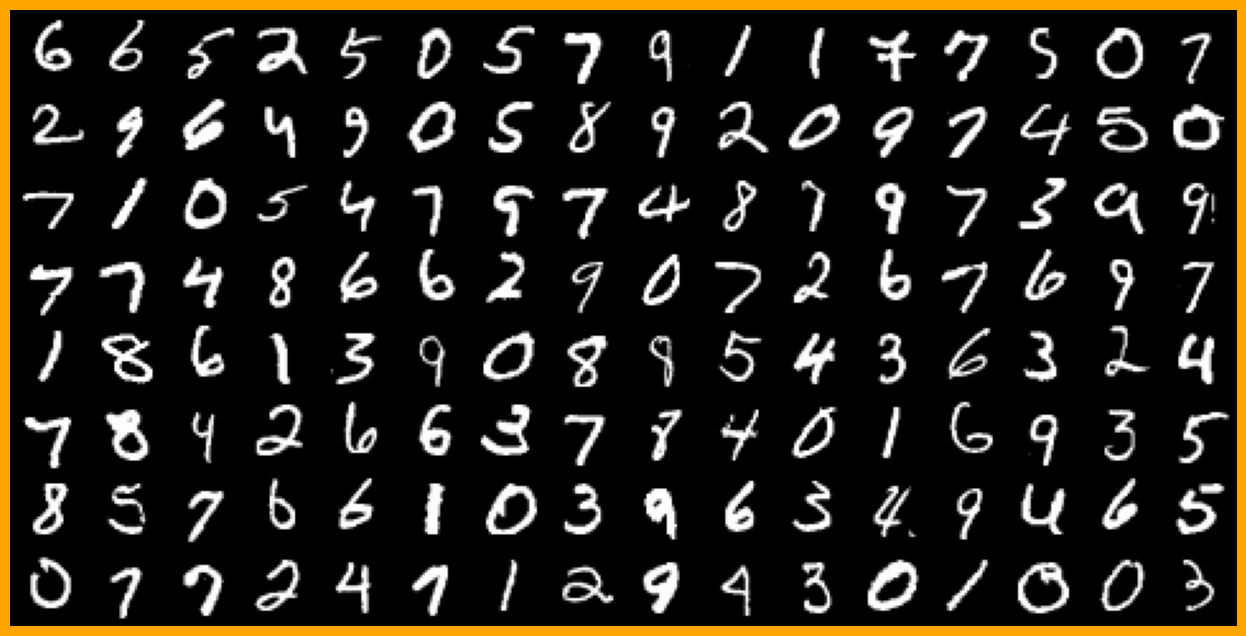

In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline
from torchvision.utils import make_grid
# Use a orange (FFA500) border background for matplotlib figures, refer for color combination https://www.w3schools.com/colors/color_tryit.asp?hex=FFFFFF
plt.rcParams['figure.facecolor'] = '#FFA500'

for images,_ in train_loader:
    print(images.shape)
    plt.figure(figsize=(16,8))
    plt.axis('off')
    plt.imshow(make_grid(images, nrow=16).permute(1,2,0))
    break

In [ ]:
import torch.nn as nn
import torch.nn.functional as F

class MnistModel(nn.Module):
    """Feedfoward neural network with 1 hidden layer"""
    def __init__(self, in_size, out_size, hidden_size):
        super().__init__()
        # hidden layer
        self.linear1 = nn.Linear(in_size, hidden_size)
        # output layer
        self.linear2 = nn.Linear(hidden_size, out_size)
    
    def forward(self, xb):
        # Flatten the image tensors
        xb = xb.reshape(-1, 784)
        # Get intermediate outputs using hidden layer 1
        out = self.linear1(xb)
        # Apply activation function
        out = F.relu(out)
        # Get predictions using output layer
        out = self.linear2(out)
        return out
    
    def training_step(self, batch):
        images, labels = batch
        out = self(images)  # Generate predictions
        loss = F.cross_entropy(out, labels) # Calculate loss
        return loss
    
    def validation_step(self, batch):
        images, labels = batch
        out = self(images)  # Generate predictions
        loss = F.cross_entropy(out, labels) # Calculate loss
        acc = accuracy(out, labels) # Calculate accuracy
        return {'val_loss': loss, 'val_acc': acc}
    
    def validation_epoch_end(self, outputs):
        batch_losses = [x['val_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()   # Combine losses
        batch_accs = [x['val_acc'] for x in outputs]
        epoch_acc = torch.stack(batch_accs).mean()  # Combine accuracies
        return {'val_loss': epoch_loss.item(), 'val_acc': epoch_acc.item()}
    
    def epoch_end(self, epoch, result):
        print("Epoch [{}], val_loss: {:.4f}, val_acc: {:.4f}".format(epoch, result['val_loss'], result['val_acc']))

def accuracy(outputs, labels):
    _, preds = torch.max(outputs, dim=1)
    return torch.tensor(torch.sum(preds == labels).item() / len(preds))

In [ ]:
input_size = 784
hidden_size = 32
output_size = 10

model = MnistModel(input_size, output_size, hidden_size)

In [ ]:
for t in model.parameters():
    print(t.shape)

torch.Size([32, 784])
torch.Size([32])
torch.Size([10, 32])
torch.Size([10])


In [ ]:
for images, labels in train_loader:
    outputs = model(images)
    loss = F.cross_entropy(outputs, labels)
    print('Loss:', loss)
    break

print('Outputs.shape', outputs.shape)
print('Sample outputs: \n', outputs[:2].data)

Loss: tensor(2.3179, grad_fn=<NllLossBackward0>)
Outputs.shape torch.Size([128, 10])
Sample outputs: 
 tensor([[ 0.0232,  0.0275, -0.1629,  0.0774,  0.1584,  0.0917,  0.1141,  0.0521,
          0.1695,  0.1245],
        [ 0.0102,  0.0631, -0.0874,  0.0447,  0.1592,  0.0427,  0.1213,  0.1045,
          0.1507,  0.0958]])


In [ ]:
torch.cuda.is_available()

True

In [ ]:
def get_default_device():
    if torch.cuda.is_available:
        return torch.device('cuda')
    else:
        return torch.device('cpu')

device = get_default_device()
device

device(type='cuda')

In [ ]:
def to_device(data, device):
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking = True)

for images, labels in train_loader:
    print(images.shape)
    images = to_device(images, device)
    print(images.device)
    break

torch.Size([128, 1, 28, 28])
cuda:0


In [ ]:
class DeviceDataLoader():
    def __init__(self, dl, device):
        self.dl = dl
        self.device =device
    
    def __iter__(self):
        for b in self.dl:
            yield to_device(b, self.device)
    
    def __len__(self):
        return len(self.dl)

In [ ]:
train_loader = DeviceDataLoader(train_loader, device)
val_loader = DeviceDataLoader(val_loader, device)

for xb,yb in val_loader:
    print(xb.shape)
    print(xb.device)
    print(yb)
    break

torch.Size([128, 1, 28, 28])
cuda:0
tensor([2, 5, 4, 5, 4, 9, 7, 3, 4, 9, 1, 1, 2, 7, 0, 5, 3, 6, 6, 9, 7, 0, 7, 6,
        7, 8, 8, 8, 4, 0, 9, 0, 1, 6, 4, 2, 3, 5, 3, 0, 7, 8, 4, 4, 5, 8, 4, 6,
        6, 4, 5, 6, 0, 4, 1, 0, 2, 0, 3, 6, 7, 6, 4, 4, 8, 8, 2, 1, 7, 7, 8, 2,
        9, 8, 8, 8, 4, 9, 8, 1, 3, 0, 0, 0, 8, 5, 1, 9, 6, 3, 2, 9, 6, 3, 4, 2,
        7, 7, 9, 3, 0, 9, 6, 2, 3, 9, 5, 2, 2, 0, 2, 0, 1, 3, 8, 7, 7, 0, 3, 8,
        6, 9, 3, 7, 4, 4, 0, 9], device='cuda:0')


In [ ]:
def evaluate(model, val_loader):
    outputs = [model.validation_step(batch) for batch in val_loader]
    return model.validation_epoch_end(outputs)

def fit(epochs, lr, model, train_loader, val_loader, opt_func= torch.optim.SGD):
    history = []
    optimizer = opt_func(model.parameters(), lr)
    for epoch in range(epochs):
        for batch in train_loader:
            loss = model.training_step(batch)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
        
        result = evaluate(model, val_loader)
        model.epoch_end(epoch, result)
        history.append(result)
    return history

In [ ]:
model = MnistModel(input_size, output_size, hidden_size)
to_device(model, device)

MnistModel(
  (linear1): Linear(in_features=784, out_features=32, bias=True)
  (linear2): Linear(in_features=32, out_features=10, bias=True)
)

In [ ]:
history = [evaluate(model, val_loader)]
history

[{'val_loss': 2.313257932662964, 'val_acc': 0.11501186341047287}]

In [ ]:
history += fit(10, 0.5, model, train_loader, val_loader)

Epoch [0], val_loss: 0.2087, val_acc: 0.9376
Epoch [1], val_loss: 0.2156, val_acc: 0.9324
Epoch [2], val_loss: 0.1466, val_acc: 0.9556
Epoch [3], val_loss: 0.1570, val_acc: 0.9533
Epoch [4], val_loss: 0.1203, val_acc: 0.9637
Epoch [5], val_loss: 0.1253, val_acc: 0.9627
Epoch [6], val_loss: 0.1431, val_acc: 0.9563
Epoch [7], val_loss: 0.1264, val_acc: 0.9600
Epoch [8], val_loss: 0.1437, val_acc: 0.9571
Epoch [9], val_loss: 0.1208, val_acc: 0.9637


In [ ]:
history += fit(5, 0.5, model, train_loader, val_loader)

Epoch [0], val_loss: 0.1445, val_acc: 0.9569
Epoch [1], val_loss: 0.1174, val_acc: 0.9642
Epoch [2], val_loss: 0.1420, val_acc: 0.9602
Epoch [3], val_loss: 0.1226, val_acc: 0.9650
Epoch [4], val_loss: 0.1190, val_acc: 0.9655


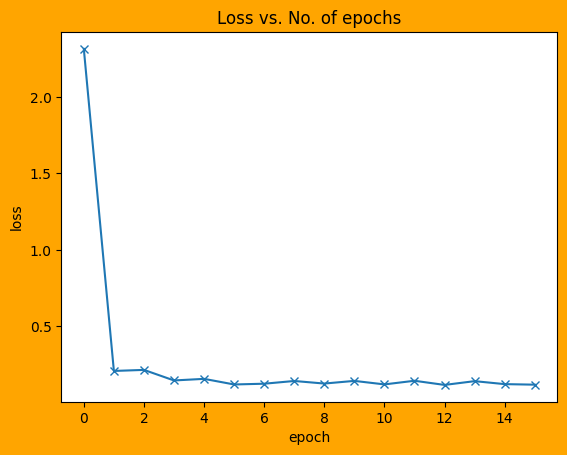

In [ ]:
losses = [x['val_loss'] for x in history]
plt.plot(losses, '-x')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.title('Loss vs. No. of epochs');

Text(0, 0.5, 'accuracy')

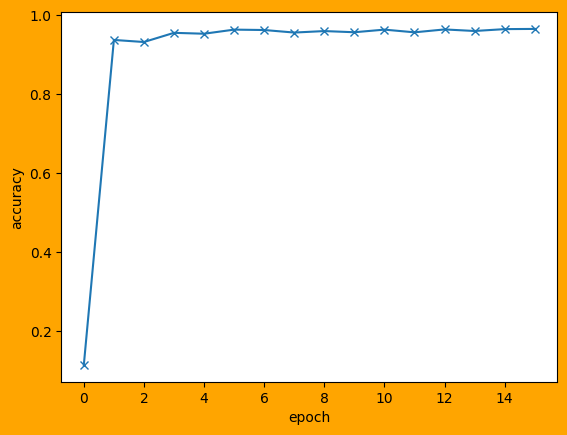

In [ ]:
accuracies = [x['val_acc'] for x in history]
plt.plot(accuracies, '-x')
plt.xlabel('epoch')
plt.ylabel('accuracy')
#plt.title('Accuracy vs. No. of epochs');

In [ ]:
test_dataset = MNIST(root='data/', 
                     train=False,
                     transform=ToTensor())

In [ ]:
test_loader = DeviceDataLoader(DataLoader(test_dataset, batch_size=256), device)
result = evaluate(model, test_loader)
result

{'val_loss': 0.10990539938211441, 'val_acc': 0.966796875}